# Introduction to the SCOPE Algorithm

### Project Roadmap
- SCOPE-Stabilized LASSO Regression (bootstrapped LASSO regression)
- Co-expression analysis and differential co-expression analysis
- Pathway Enrichment with Over Representation Analysis

## Why SCOPE?

In [1]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import norm
import plotly.express as px
import plotly
import plotly.graph_objects as go
import plotly.subplots as sp
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("data-cleaned-for-use/GSE98394_final.csv").drop(["Unnamed: 0"], axis=1)
replace = {" Solid Tissue Normal": "Common acquired nevus", " Primary Tumor": "Primary melanoma"}
df["phen"] = df["phen"].replace(replace, regex=True)

common_nevus = 0
primary_melanoma = 0
for ind, row in df.iterrows():
    condition = row["phen"]
    if condition == "Common acquired nevus":
        common_nevus += 1
    elif condition == "Primary melanoma":
        primary_melanoma += 1

df.head()

,names,ENSG00000188976,ENSG00000187608,ENSG00000188157,ENSG00000131591,ENSG00000186891,ENSG00000078808,ENSG00000176022,ENSG00000184163,ENSG00000160087,...,ENSG00000124333,ENSG00000129824,ENSG00000067646,ENSG00000114374,ENSG00000067048,ENSG00000183878,ENSG00000165246,ENSG00000012817,ENSG00000198692,phen
0,JC050,4.793051,2.073840,5.209481,2.570516,1.773628,4.443529,3.108706,0.065345,3.701456,...,5.311777,-6.923340,-6.923340,-6.923340,-6.923340,-6.923340,-6.923340,-6.923340,-6.923340,Common acquired nevus
1,JC052,4.807509,2.424415,4.153767,2.357817,3.220882,4.516338,3.057033,1.041558,3.924489,...,6.400489,-6.952795,-6.952795,-3.493364,-4.630867,-4.630867,-3.493364,-3.782870,-6.952795,Common acquired nevus
2,JC053,5.398071,3.356930,5.003010,3.412835,3.351491,5.341580,3.717689,0.895461,4.149278,...,5.979182,-4.375068,-6.696996,-4.375068,-4.375068,-6.696996,-6.696996,-3.527071,-6.696996,Common acquired nevus
3,JC054,5.523682,3.174818,5.225841,2.613122,2.999979,4.809339,2.978202,0.996733,3.595350,...,6.043226,-7.382645,-7.382645,-7.382645,-5.060717,-7.382645,-7.382645,-7.382645,-7.382645,Common acquired nevus
4,JC055,4.921878,2.601513,4.410262,2.662669,3.205225,4.849749,3.915218,1.008720,4.192968,...,6.198626,-6.927918,-6.927918,-6.927918,-4.605989,-6.927918,-6.927918,-6.927918,-6.927918,Common acquired nevus


In [3]:
print("Number of patients with common acquired nevus is: " + str(common_nevus) + ".")
print("Number of patients with primary melanoma is: " + str(primary_melanoma) + ".")

Number of patients with common acquired nevus is: 27.
Number of patients with primary melanoma is: 51.


## LASSO-Regression

In [4]:
lasso_summary = pd.read_csv("data-processed-changed/stabilized_lasso_Summary.csv").sort_values(by="model.count", ascending=False)
lasso_summary.rename(columns={"model.count":"model_count", "min.val":"min_val", "max.val":"max_val"}, inplace=True)
lasso_summary.head()

,probe,model_count,min_val,max_val
3,ENSG00000008130,957,0.000041,1.565865
93,ENSG00000172456,948,-2.005558,-0.000041
60,ENSG00000152022,907,0.000018,1.689454
63,ENSG00000154309,869,-1.423527,-0.000138
39,ENSG00000125703,734,-1.145421,-0.000004


In [5]:
# construct horizontal bar chart with top 30 hits of model count from lasso_head dataframe 
lasso_top_30 = lasso_summary.head(30)

# set threshold value
threshold_value = 800
threshold_genes = lasso_top_30[lasso_top_30["model_count"] > threshold_value]
print("There are " + str(len(threshold_genes)) + "genes that had greater hits than the threshold value. \n" +
     "They are: " + str(threshold_genes["probe"].unique()) + ".")
threshold_genes

There are 4genes that had greater hits than the threshold value. 
They are: ['ENSG00000008130' 'ENSG00000172456' 'ENSG00000152022' 'ENSG00000154309'].


,probe,model_count,min_val,max_val
3,ENSG00000008130,957,0.000041,1.565865
93,ENSG00000172456,948,-2.005558,-0.000041
60,ENSG00000152022,907,0.000018,1.689454
63,ENSG00000154309,869,-1.423527,-0.000138


In [6]:
# rearrange dataframe
lasso_melt = pd.melt(lasso_top_30, id_vars=["probe", "model_count"], value_vars=["min_val", "max_val"])
rename_variable = {"min_val":"Minimum Value", "max_val": "Maximum Value"}
lasso_melt["variable"] = lasso_melt["variable"].replace(rename_variable)
lasso_melt.head()

,probe,model_count,variable,value
0,ENSG00000008130,957,Minimum Value,0.000041
1,ENSG00000172456,948,Minimum Value,-2.005558
2,ENSG00000152022,907,Minimum Value,0.000018
3,ENSG00000154309,869,Minimum Value,-1.423527
4,ENSG00000125703,734,Minimum Value,-1.145421


Text(0.5, 0.001, 'Figure 1. Comparing number of counts, minimum value of coefficient, and maximum value of coefficients of top 30 model count genes.')

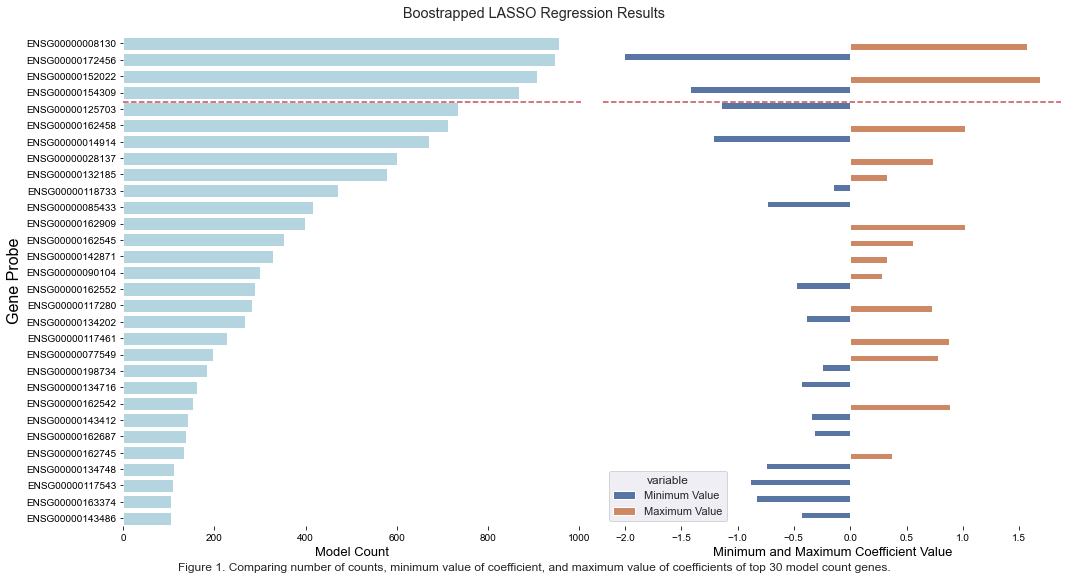

In [7]:
# stabilized LASSO regression visualizations
fig, axis = plt.subplots(1,2, sharex=False, figsize=(15, 8))
sns.set(style="darkgrid")
fig.suptitle("Boostrapped LASSO Regression Results")
sp1 = sns.barplot(ax=axis[0], x=lasso_top_30.model_count, y=lasso_top_30.probe, color="lightblue")
sp1.set_ylabel("Gene Probe", fontsize=16)
sp1.set_xlabel("Model Count", fontsize=13)
sp1.axhline(3.55, 0, 3, color="r", ls="--")
sp2 = sns.barplot(ax=axis[1], data=lasso_melt, x="value", y="probe", hue="variable")
sp2.set(ylabel=None)
sp2.set_xlabel("Minimum and Maximum Coefficient Value", fontsize=13)
sns.despine(left=True, bottom=True)
for i in range(1, len(axis)):
    axis[i].set_ylim(axis[0].get_ylim())
    axis[i].set_yticks([])
fig.tight_layout()
sp2.axhline(3.6, 0, 2, color="r", ls="--")
fig.text(0.5, 0.001, "Figure 1. Comparing number of counts, minimum value of coefficient, and maximum value of coefficients of top 30 model count genes.", ha="center")

In [ ]:
cleaned_pathways = pd.read_csv("data-final-outcomes/csv/GSE98394_sheet2.csv")
cleaned_pathways.head()

Mywords